In [2]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs






# LOAD CONTACT MATRICES
# contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')
# contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed_no_chrY.npy')

# contact_matrix_zero = np.load('data/hic/knockout_100kb_balanced_zeroed.npy')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
contact_matrix_zero = np.load('data/hic/full_imputed_zeroed.npy')

## Greedy

In [3]:
ttn_clique_greedy = cf.find_greedy_clique(contact_matrix=contact_matrix_zero, n=5, target_bin=TTN_BIN)

In [4]:
ttn_clique_greedy

[4275, 28240, 393, 29042, 13146]

/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_11675/3259725782.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


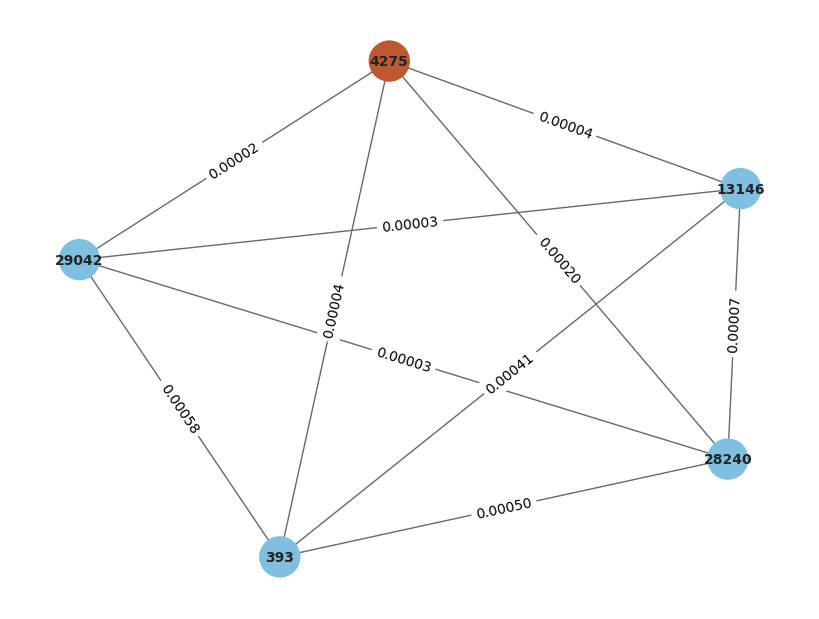

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def clique_to_graph(contact_matrix, clique, selected_bin=None):
    
    edges = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            edges.append((clique[i], clique[j], contact_matrix[clique[i], clique[j]]))

    G = nx.Graph()
    G.add_nodes_from(clique)
    G.add_weighted_edges_from(edges)

    base_color = '#7fbfdf'    
    highlight_color = "#bd5931" 
    node_colors = [highlight_color if bin == selected_bin else base_color for bin in clique]

    pos = nx.spring_layout(G, seed=42)
    # pos = nx.circular_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=800, node_color=node_colors,
            font_size=10, font_weight='bold', edge_color='dimgray', linewidths=1.5, font_color="#232323")

    labels = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.5f}" for k, v in labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    plt.tight_layout()
    plt.show()
    return G

clique_to_graph(contact_matrix_zero, ttn_clique_greedy, selected_bin=TTN_BIN)

In [6]:
core.stats.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique_greedy)

0.00019294358208737377

In [7]:
def optimize_clique_size(
    contact_matrix,
    max_clique_size,
    seed_bin,
    num_samples=1000,
    clique_alg=cf.find_greedy_clique,
    **alg_kwargs
):
    """
    Runs a single full-size clique search with `clique_alg`, then trims down to all sizes.

    Parameters:
    - contact_matrix: Hi-C contact matrix
    - max_clique_size: maximum clique size to search
    - seed_bin: start bin for your TTN clique
    - num_samples: number of random background samples
    - clique_alg: function(contact_matrix, size, seed_bin, **alg_kwargs)
    - alg_kwargs: extra keyword arguments for `clique_alg` (e.g. num_neighbors)

    Returns:
    sizes, ttn_scores, p_values, fold_changes, bg_dists
    """
    print(f"Starting optimize_clique_size: max_clique_size={max_clique_size}, "
          f"seed_bin={seed_bin}, num_samples={num_samples}, alg={clique_alg.__name__}")

    # 1) Full-size TTN clique
    ttn_full = clique_alg(
        contact_matrix,
        max_clique_size,
        seed_bin,
        **alg_kwargs
    )
    print(f"Computed TTN full clique of size {len(ttn_full)} using {clique_alg.__name__}")

    # 2) Background samples (full size)
    bg_full = []
    for _ in tqdm(range(num_samples), desc="Sampling background cliques"):
        rand_bin = np.random.randint(contact_matrix.shape[0])
        bg = clique_alg(
            contact_matrix,
            max_clique_size,
            rand_bin,
            **alg_kwargs
        )
        bg_full.append(bg)
    print("Background sampling complete.")

    sizes = list(range(1, max_clique_size + 1))
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    # 3) Trim & score for each size
    for size in tqdm(sizes, desc="Processing sizes"):

        # TTN subclique
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(
            contact_matrix,
            ttn_sub
        )
 

        # Background scores
        bg_scores = []
        for clique in bg_full:
            sub = clique[:size]
            score = core.stats.calculate_avg_interaction_strength(
                contact_matrix,
                sub
            )
            bg_scores.append(score)
        bg_dists[size] = bg_scores

        # Stats
        median_bg = np.median(bg_scores)
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (num_samples + 1)
        fold = ttn_score / median_bg if median_bg != 0 else float('nan')

        # print(f"  Median background: {median_bg:.4f}")
        # print(f"  p-value: {pval:.4f}")
        # print(f"  Fold change: {fold:.4f}")

        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("Completed optimize_clique_size")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists



In [8]:
sizes, ttn_scores, pvals, folds, bg = optimize_clique_size(
    contact_matrix_zero,
    max_clique_size=30,
    seed_bin=4275,
    num_samples=10000,
)

Starting optimize_clique_size: max_clique_size=30, seed_bin=4275, num_samples=10000, alg=find_greedy_clique
Computed TTN full clique of size 30 using find_greedy_clique


Sampling background cliques: 100%|██████████| 10000/10000 [10:54<00:00, 15.29it/s]


Background sampling complete.


Processing sizes: 100%|██████████| 30/30 [00:07<00:00,  4.23it/s]

Completed optimize_clique_size


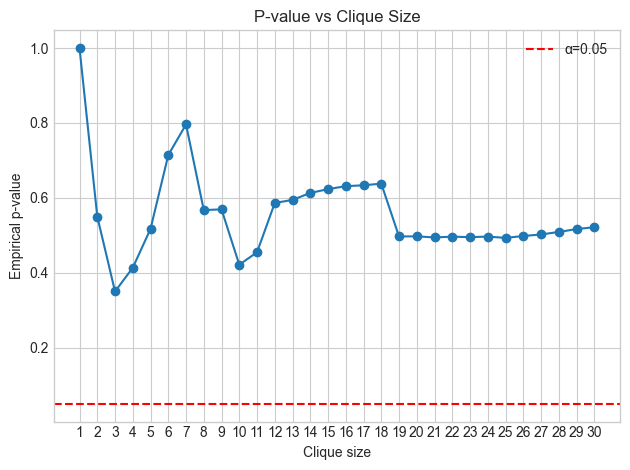

Optimal clique size = 3, p-value = 0.3500


In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')  # Clean modern look
# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, pvals, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(pvals))
opt_size = sizes[opt_idx]
opt_pval = pvals[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')

/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_11675/3259725782.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


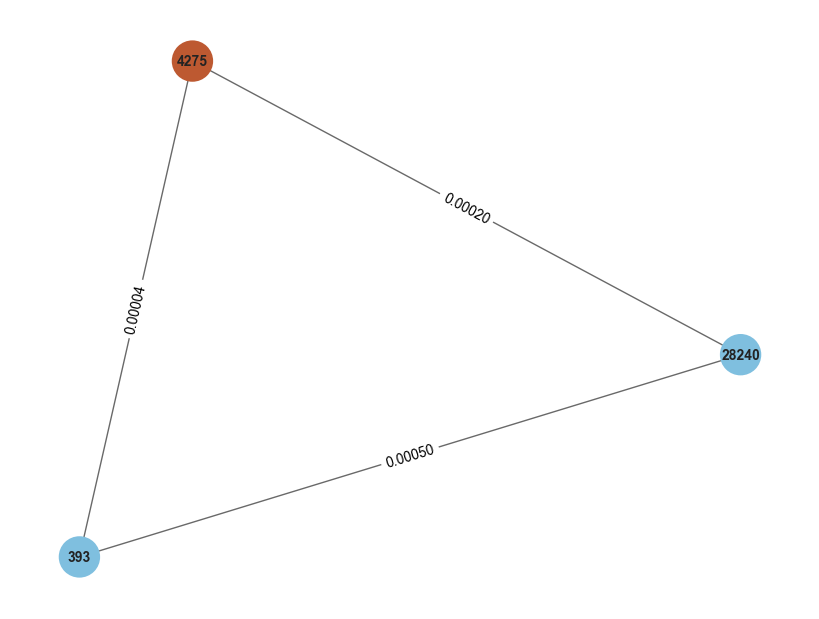

In [12]:
ttn_clique_greedy = cf.find_greedy_clique(
    contact_matrix=contact_matrix_zero,
    n=opt_size,
    target_bin=TTN_BIN
)

ttn_clique_greedy
clique_to_graph(contact_matrix_zero, ttn_clique_greedy, selected_bin=TTN_BIN)

## Diffusion

In [92]:
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')


In [ ]:
ttn_clique_diffusion, visits = cf.analytical_diffusion_clique(contact_matrix=contact_matrix_zero, start_node=TTN_BIN, n=11, alpha=0.25)

# save visits
np.save("ttn_visits _diffusion_alpha_0.25.npy", visits)

In [11]:
visits = np.load("ttn_visits_diffusion_alpha_0.25.npy")
ttn_clique_diffusion = np.argsort(visits)[-18:][::-1]
ttn_clique_diffusion

array([ 4275, 30478, 28240, 25715, 24025,   102, 24877, 28248, 18748,
       16721, 25720, 22159, 28550, 28238, 24884, 16698, 25721, 11003])

In [8]:
core.stats.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique_diffusion)

6.491271872384311e-05

In [14]:
from tqdm import tqdm

TTN_GENES = set()
for bin in tqdm(ttn_clique_diffusion):
    genes = f.find_gene_from_bin(bin, BIN_MAP_PATH, GTF_PATH)
    TTN_GENES.update(genes)


    

100%|██████████| 18/18 [02:09<00:00,  7.17s/it]


In [15]:
len(TTN_GENES)

898

In [16]:

with open("wt_ttn_diffusion_genes_TEST_18.txt", 'w') as out:
    for bin in TTN_GENES:
        out.write(f"{bin}\n")


In [ ]:
# load txt bin list from alpha=0.05 with from res/TTN_BINS_ANALYTICAL_DIFFUSION.txt

with open('res/TTN_BINS_ANALYTICAL_DIFFUSION.txt', 'r') as file:
    ttn_bins_alpha_25= file.read().splitlines()
ttn_bins_alpha_25 = [int(x) for x in ttn_bins_alpha_25]

In [13]:
np.intersect1d(ttn_bins_alpha_25, ttn_clique_diffusion)

NameError: name 'ttn_bins_alpha_25' is not defined

In [ ]:
from tqdm import tqdm

TTN_GENES_TEST = set()
for bin in tqdm(np.intersect1d(ttn_bins_alpha_25, ttn_clique_diffusion)):
    genes = f.find_gene_from_bin(bin, BIN_MAP_PATH, GTF_PATH)
    TTN_GENES_TEST.update(genes)


    

100%|██████████| 7/7 [00:54<00:00,  7.82s/it]


In [117]:
list(TTN_GENES_TEST)
with open("wt_ttn_diffusion_genes_TEST.txt", 'w') as out:
    for bin in TTN_GENES_TEST:
        out.write(f"{bin}\n")


In [103]:
core.stats.calculate_avg_interaction_strength(contact_matrix_zero, ttn_bins_alpha_25)

0.00028100787694961584

In [89]:
with open("wt_ttn_diffusion_genes_40bins.txt", 'w') as out:
    for bin in TTN_GENES:
        out.write(f"{bin}\n")


/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_97460/3739873365.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


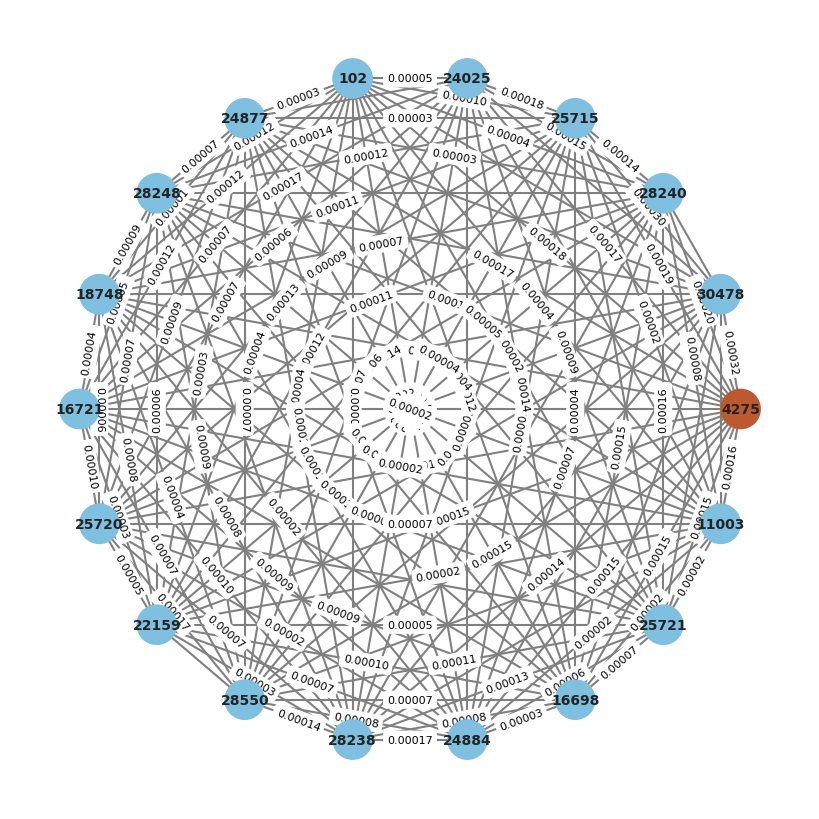

In [12]:
# Create a graph from the clique
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def clique_to_graph(contact_matrix, clique, selected_bin=None):
    
    edges = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            weight = contact_matrix[clique[i], clique[j]]
            edges.append((clique[i], clique[j], weight))

    G = nx.Graph()
    G.add_nodes_from(clique)
    G.add_weighted_edges_from(edges)

    base_color = '#7fbfdf'    
    highlight_color = "#bd5931"
    node_colors = [highlight_color if bin == selected_bin else base_color for bin in clique]

    pos = nx.circular_layout(G)  # Handles large cliques well

    plt.figure(figsize=(8, 8))
    nx.draw(
        G, pos, with_labels=True, node_size=800, node_color=node_colors,
        font_size=10, font_weight='bold', edge_color='gray', width=1.5, font_color="#232323"
    )

    # Show all nonzero edge weights, even if very small
    labels = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.5f}" for k, v in labels.items() if v != 0.0}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

    plt.tight_layout()
    plt.show()
    return G
    
    
clique_to_graph(contact_matrix_zero, ttn_clique_diffusion, selected_bin=TTN_BIN)

/opt/anaconda3/envs/expanse38/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/opt/anaconda3/envs/expanse38/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/anaconda3/envs/expanse38/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


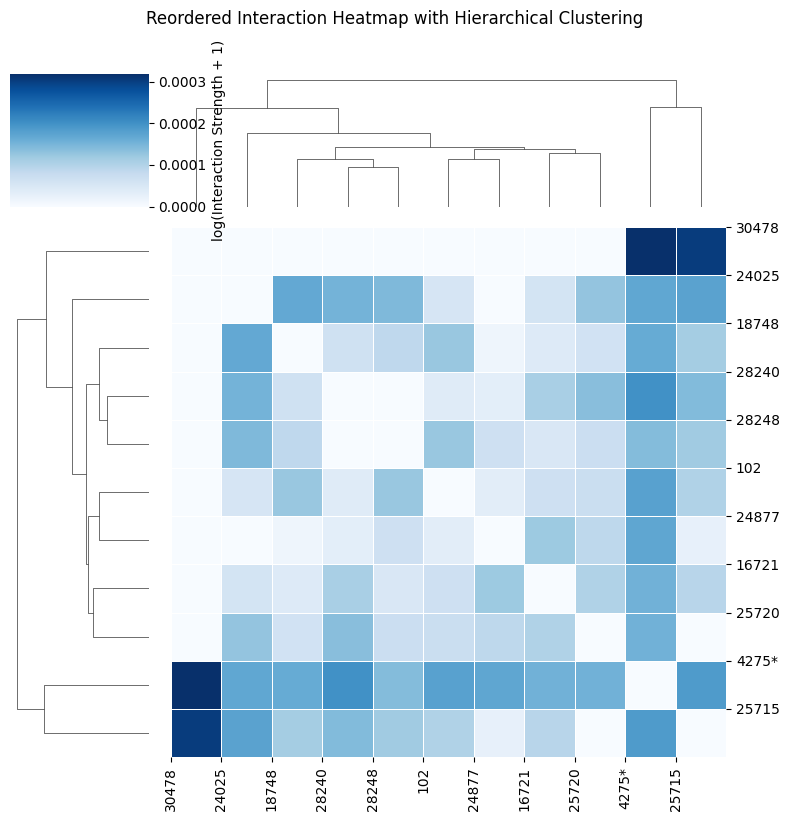

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_reordered_heatmap(contact_matrix, clique, selected_bin=None):
    # Extract submatrix
    submatrix = contact_matrix[np.ix_(clique, clique)]
    
    # Log-transform to improve low-value contrast
    norm_matrix = np.log1p(submatrix)

    # Plot clustermap with no tick labels initially
    cluster = sns.clustermap(
        norm_matrix,
        cmap="Blues",
        linewidths=0.5,
        figsize=(8, 8),
        square=True,
        dendrogram_ratio=(0.2, 0.2),
        cbar_kws={'label': 'log(Interaction Strength + 1)'},
        xticklabels=False,
        yticklabels=False
    )

    # Get the order of bins after clustering
    reordered_idx = cluster.dendrogram_row.reordered_ind
    reordered_bins = [clique[i] for i in reordered_idx]

    # Build formatted labels
    ordered_labels = [
        f"{b}*" if b == selected_bin else str(b)
        for b in reordered_bins
    ]

    # Apply reordered labels manually
    cluster.ax_heatmap.set_xticks(np.arange(len(clique)))
    cluster.ax_heatmap.set_yticks(np.arange(len(clique)))
    cluster.ax_heatmap.set_xticklabels(ordered_labels, rotation=90)
    cluster.ax_heatmap.set_yticklabels(ordered_labels)

    # Add title above clustermap
    plt.suptitle("Reordered Interaction Heatmap with Hierarchical Clustering", y=1.02)
    plt.tight_layout()
    plt.show()

plot_reordered_heatmap(contact_matrix_zero, ttn_clique_diffusion, selected_bin=TTN_BIN)

In [54]:
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')

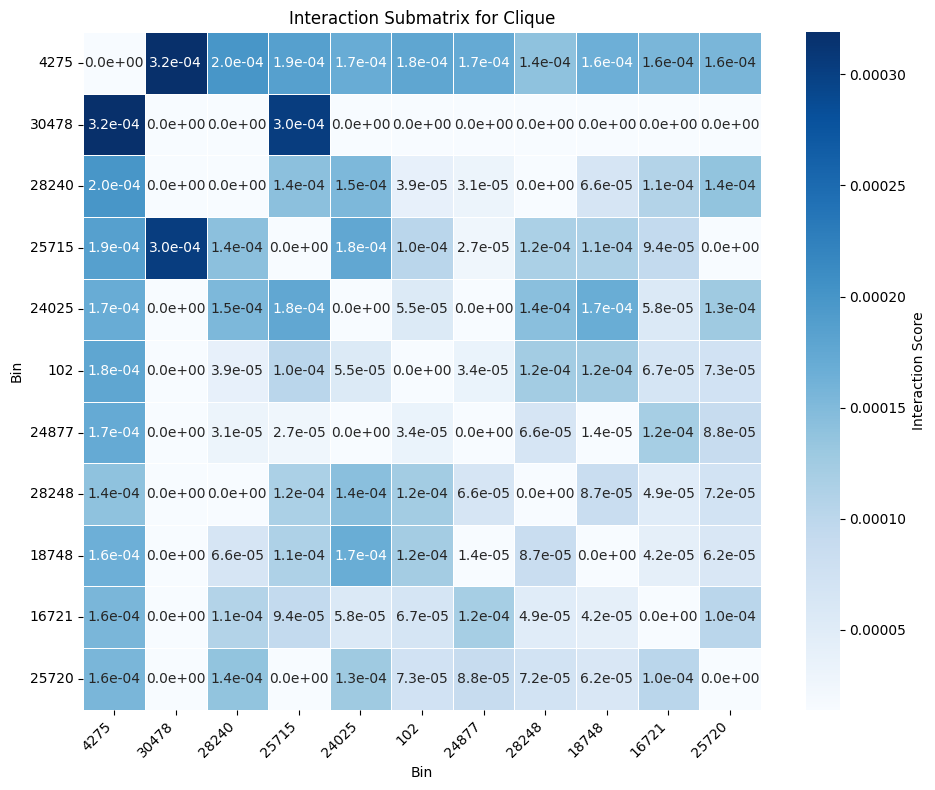

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_clique_heatmap(contact_matrix, clique):
    # Extract submatrix and bin labels
    submatrix = contact_matrix[np.ix_(clique, clique)]
    labels = [int(b) for b in clique]

    # Handle low values: display in scientific notation
    sub_rounded = np.round(submatrix.astype(float), 8)

    # Mask for colormap scaling: exclude zeros if possible
    nonzero_vals = sub_rounded[sub_rounded > 0]
    vmin = nonzero_vals.min() if nonzero_vals.size > 0 else 0
    vmax = nonzero_vals.max() if nonzero_vals.size > 0 else 1

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        sub_rounded,
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues",
        square=True,
        annot=True,
        fmt=".1e",  # scientific notation
        linewidths=0.5,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Interaction Score'}
    )

    plt.title("Interaction Submatrix for Clique")
    plt.xlabel("Bin")
    plt.ylabel("Bin")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
plot_clique_heatmap(contact_matrix_zero, ttn_clique_diffusion)

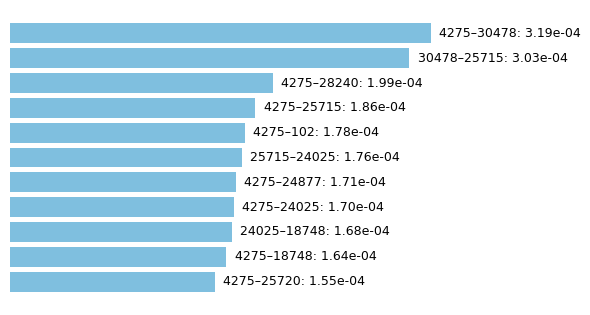

[((4275, 30478), 0.0003189167624610926),
 ((30478, 25715), 0.00030273964987794356),
 ((4275, 28240), 0.0001993284699748872),
 ((4275, 25715), 0.00018596370839719817),
 ((4275, 102), 0.0001779535218071905),
 ((25715, 24025), 0.00017578706259095494),
 ((4275, 24877), 0.00017144639965483452),
 ((4275, 24025), 0.00016974867403207335),
 ((24025, 18748), 0.0001681355078901356),
 ((4275, 18748), 0.0001641869452715817),
 ((4275, 25720), 0.00015538280945030154)]

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_pair_bars_simple(contact_matrix, clique, top_n=11):
    # 1) Gather all pairwise scores
    data = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            b1, b2 = int(clique[i]), int(clique[j])
            score = contact_matrix[b1, b2]
            data.append(((b1, b2), score))

    # 2) Sort and take top_n
    data = sorted(data, key=lambda x: x[1], reverse=True)[:top_n]
    pairs, scores = zip(*data)
    max_score = max(scores)

    # 3) Plot
    fig_height = max(2, 0.25 * len(pairs) + 0.5)
    fig, ax = plt.subplots(figsize=(6, fig_height))
    y_pos = np.arange(len(pairs))
    bars = ax.barh(y_pos, scores, color='#7fbfdf')
    ax.invert_yaxis()

    # 4) Hide axes
    ax.axis('off')

    # 5) Label each bar with "bin1–bin2: score"
    for (b1, b2), score, bar in zip(pairs, scores, bars):
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            x + max_score * 0.02,  # small offset to the right
            y,
            f"{b1}–{b2}: {score:.2e}",
            va='center',
            ha='left',
            fontsize=9
        )

    plt.tight_layout()
    plt.show()
    return data

plot_top_pair_bars_simple(contact_matrix_zero, ttn_clique_diffusion, top_n=11)

In [40]:
core.stats.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique_diffusion)

6.075162523890684e-05

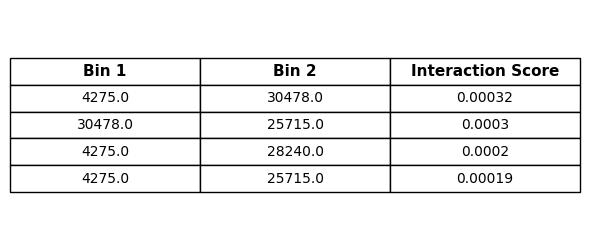

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_top_contacts(contact_matrix, clique, top_n=11):
    # Extract upper triangle values only for unique pairs
    data = []
    for i in range(len(clique)):
        for j in range(i + 1, len(clique)):
            bin1, bin2 = clique[i], clique[j]
            score = contact_matrix[bin1, bin2]
            data.append((bin1, bin2, score))

    # Create DataFrame and sort by score descending
    df = pd.DataFrame(data, columns=["Bin 1", "Bin 2", "Interaction Score"])
    df = df.sort_values("Interaction Score", ascending=False).head(top_n)

    # Plot using matplotlib table
    fig, ax = plt.subplots(figsize=(6, 0.4 * top_n + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.round(5).values,
        colLabels=df.columns,
        loc='center',
        cellLoc='center'
    )
    table.scale(1, 1.4)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Optional: bold header row
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # header
            cell.set_fontsize(11)
            cell.set_text_props(weight='bold')

    plt.tight_layout()
    plt.show()
    return df

top_df = plot_top_contacts(contact_matrix_zero, ttn_clique_diffusion, top_n=4)

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_diffusion_tree(contact_matrix, clique, seed_bin):
    # Build weighted undirected graph
    G = nx.Graph()
    for i in range(len(clique)):
        for j in range(i + 1, len(clique)):
            bin1, bin2 = clique[i], clique[j]
            score = contact_matrix[bin1, bin2]
            G.add_edge(bin1, bin2, weight=score)

    # Convert to shortest-path tree from seed
    T = nx.bfs_tree(G, source=seed_bin)

    # Use spring layout or hierarchy if available
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(T, prog="dot")
    except ImportError:
        pos = nx.spring_layout(T, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(
        T, pos, with_labels=True, node_size=800,
        node_color='#7fbfdf', font_size=10, font_weight='bold',
        edge_color='gray', width=1.5, arrows=True
    )

    plt.title(f"Diffusion Tree from Seed Bin {seed_bin}", fontsize=12)
    plt.tight_layout()
    plt.show()

    return T

/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_3639/3243067555.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


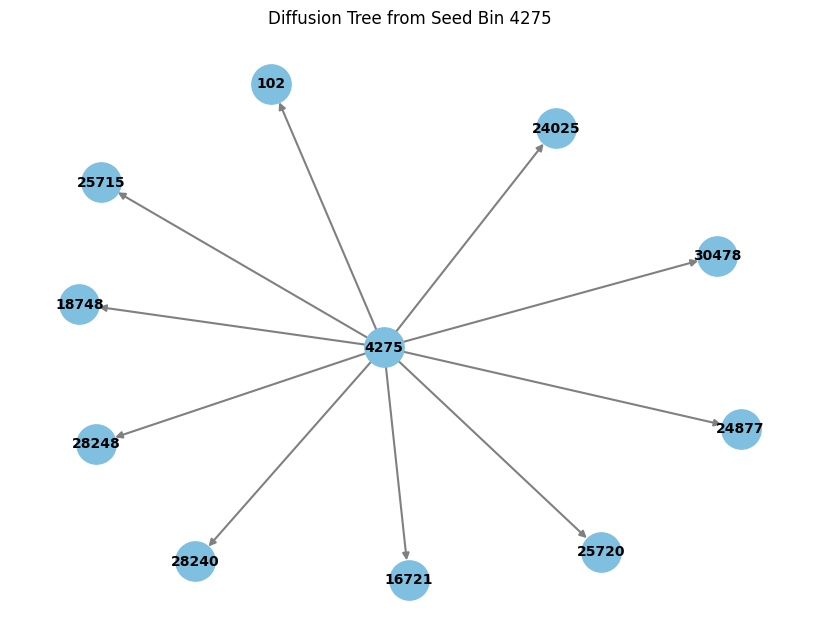

In [22]:
plot_diffusion_tree(contact_matrix_zero, ttn_clique_diffusion, seed_bin=TTN_BIN)